In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
from mlflow.models import infer_signature
import subprocess
import time
import webbrowser


# **1. LOADING THE DATASET**

In [2]:
# CONSTANTS
S3_BUCKET_NAME = 'c0943861-ab-nyc-dataset-2025'
S3_FILE_KEY = 'data/AB_NYC_2019.csv' 
AWS_REGION = 'us-east-1'

In [3]:
# Load dataset function
def load_from_s3(bucket_name, file_key, region):
    try:
        s3 = boto3.client('s3', region_name=region)
        obj = s3.get_object(Bucket=bucket_name, Key=file_key)
        df = pd.read_csv(obj['Body'])
        return df
    except:
        print("Error reading the file from S3.")
        return None

In [4]:
df2 = load_from_s3(S3_BUCKET_NAME, S3_FILE_KEY, AWS_REGION)

In [5]:
df2.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# **2. DATA PREPROCESSING**

## **2.1.** Feature Engineering

- By security reasons and by efficiency, columns with identifiers are going to be removed.

In [7]:
# removing columns with identifiers
df2.drop(columns=['id', 'name', 'host_id', 'host_name'], inplace=True)

In [8]:
df2.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


- As can be seen, the minimum value of the target feature **price** is zero, which by the information in the *data dictionary* it doesnt make much sense. Of course, before to remove the responsible for the business must be conslted about the possibility of prices being zero. As an academic project, this value will be removed.

In [9]:
# removing prices equal to zero
df2 = df2[df2['price'] > 0]

- In order to make it easier for the model to read the dataset, the feature *last_review* will be changed to *days_since_last_review*, since works with integers are more efficient than using *datetime* format.

- In the case of outliers in *days_since_last_review*, the fact there are missing values doesn't mean that this values would be changed to zero (meaning that people make the review today), but that **no one never make a review** or **problems in data collection**.

- So, the less problematic option to handle with these missing values is inputting the **maximun** value (that tries to indicate that people never post any review). Of course, there are some challenges, because it will search based in other rows which is the maximun value, which can lead to not accurate information being inputted.

In [10]:
# converting df2['last_review'] to df2["days_since_last_review"]
df2['last_review'] = pd.to_datetime(df2['last_review'], errors='coerce')
df2['days_since_last_review'] = (pd.to_datetime('today') - df2['last_review']).dt.days

# determining the maximum days_since_last_review to fill NaN values
max_days = df2['days_since_last_review'].max()
df2['days_since_last_review'] = df2['days_since_last_review'].fillna(max_days)

# converting df2['days_since_last_review'] to integer
df2['days_since_last_review'] = df2['days_since_last_review'].astype('Int64')

# removing the original 'last_review' column
df2.drop(columns=['last_review'], inplace=True)

In [11]:
if "reviews_per_month" in df2.columns and "number_of_reviews" in df2.columns:
    rpm = df2["reviews_per_month"].copy()
    median_rpm = rpm.median()

    # Missing values => 0 by default
    rpm = rpm.fillna(0)

    # Using median for listings with reviews but missing rpm
    mask_has_reviews = df2["number_of_reviews"] > 0
    rpm.loc[mask_has_reviews & (rpm == 0)] = median_rpm

    df2["reviews_per_month"] = rpm

In [12]:
# verifying nan values
df2.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_last_review            0
dtype: int64

- There aren't *NaN* values in the dataset.

In [13]:
# verifying nan values
df2.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_last_review            0
dtype: int64

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48884 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48884 non-null  object 
 1   neighbourhood                   48884 non-null  object 
 2   latitude                        48884 non-null  float64
 3   longitude                       48884 non-null  float64
 4   room_type                       48884 non-null  object 
 5   price                           48884 non-null  int64  
 6   minimum_nights                  48884 non-null  int64  
 7   number_of_reviews               48884 non-null  int64  
 8   reviews_per_month               48884 non-null  float64
 9   calculated_host_listings_count  48884 non-null  int64  
 10  availability_365                48884 non-null  int64  
 11  days_since_last_review          48884 non-null  Int64  
dtypes: Int64(1), float64(3), int64(5), ob

##### Handling with outliers

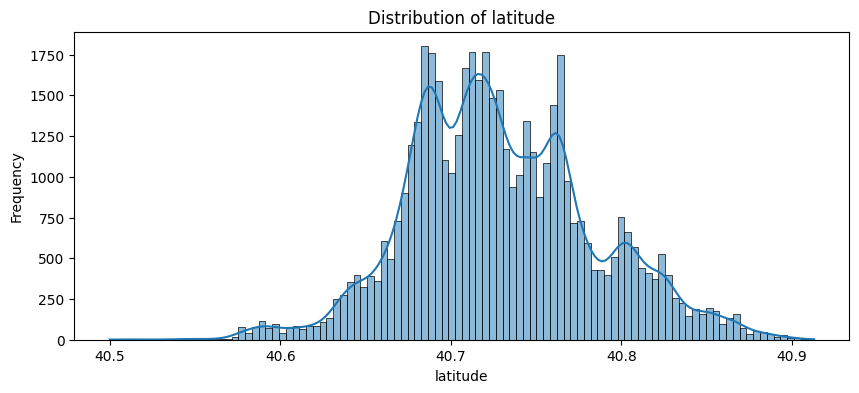

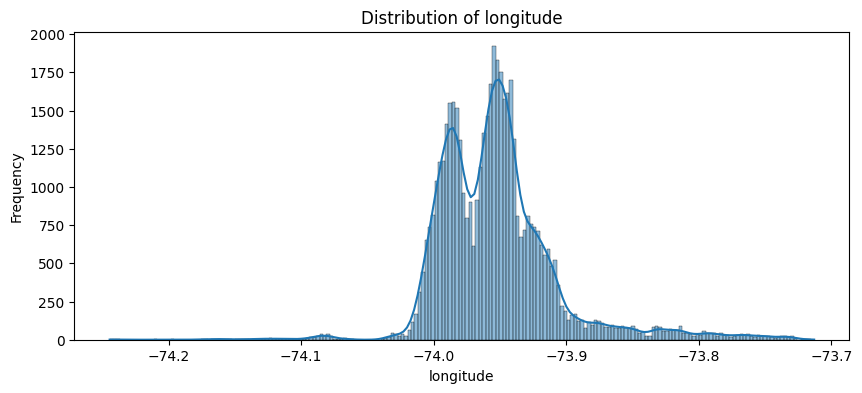

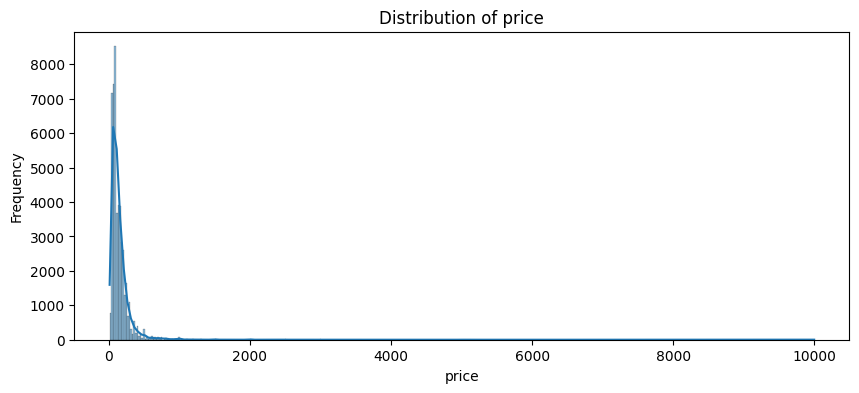

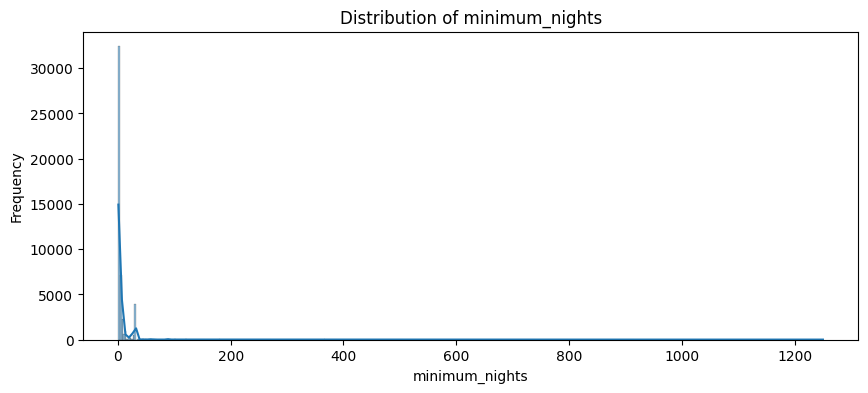

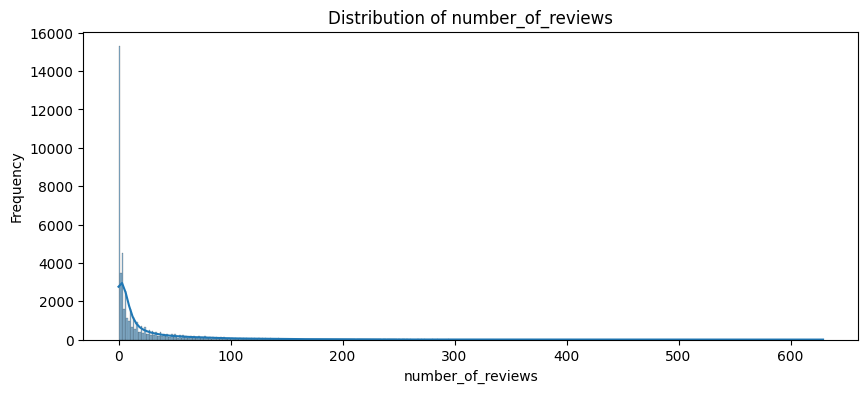

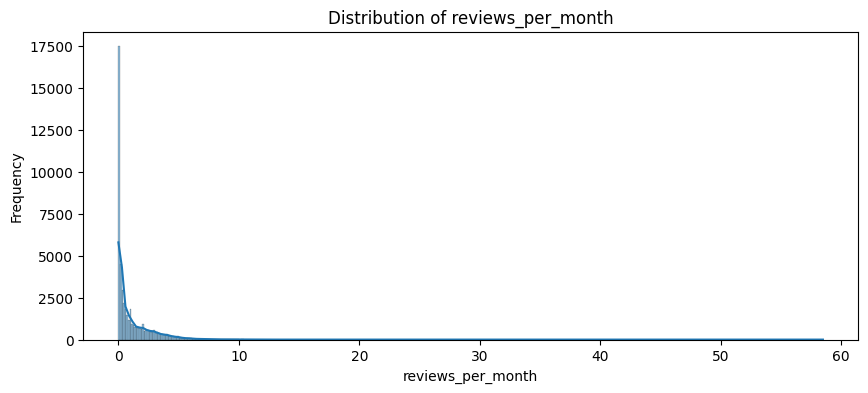

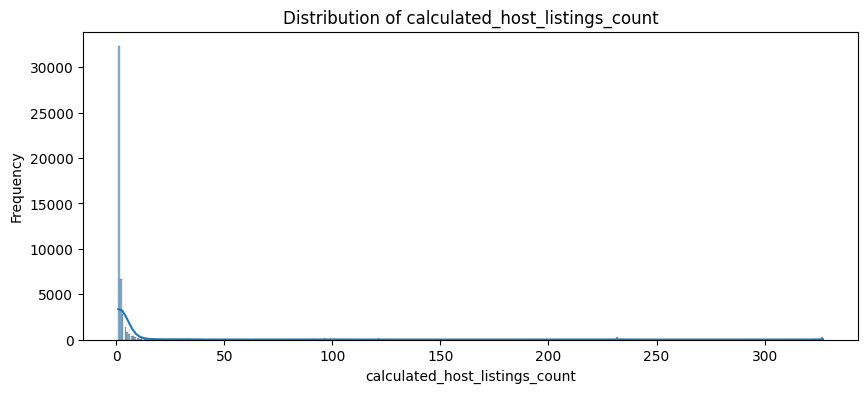

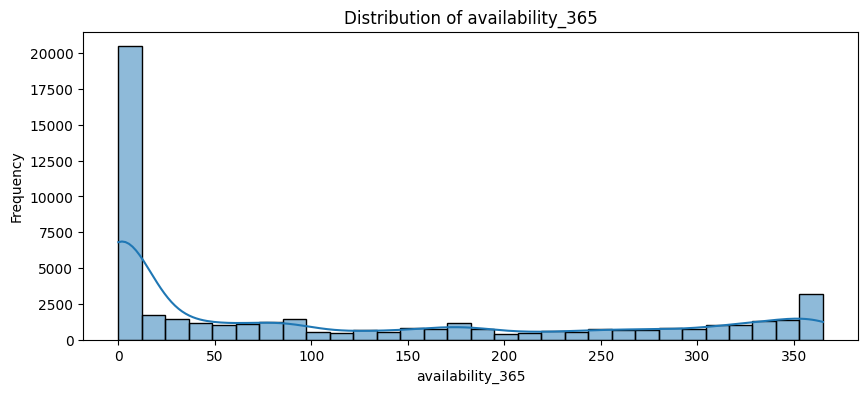

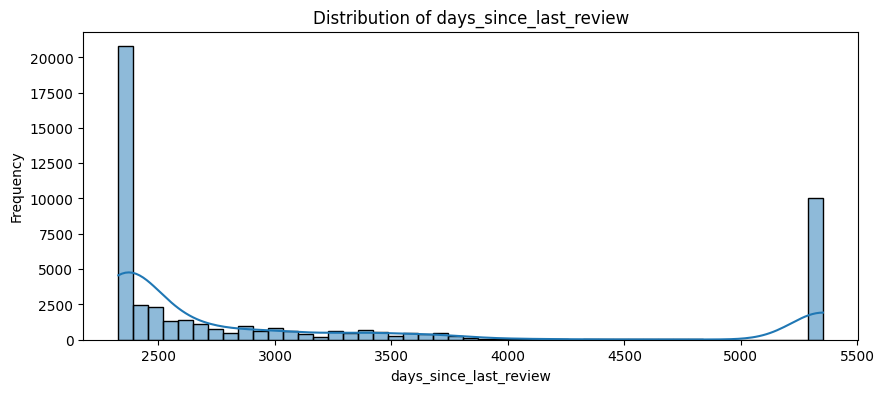

In [15]:
# Visualizing distribution in all columns
for column in df2.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df2[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [16]:
# selecting numerical values for outlier treatment
numerical_cols = df2.select_dtypes(include=['int64', 'float64']).columns

# treating outliers using IQR method
for col in numerical_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df2 = df2[(df2[col] >= lower_bound) & (df2[col] <= upper_bound)]

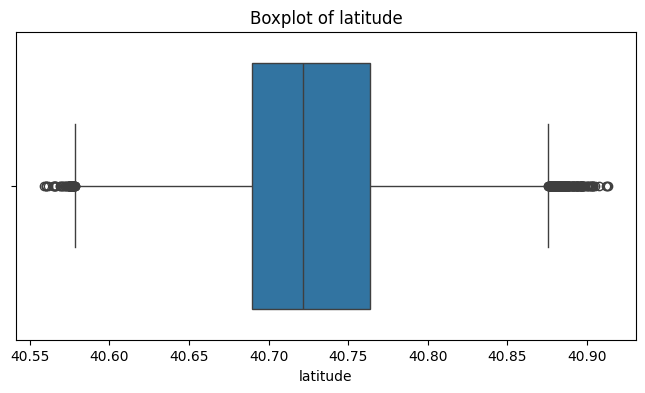

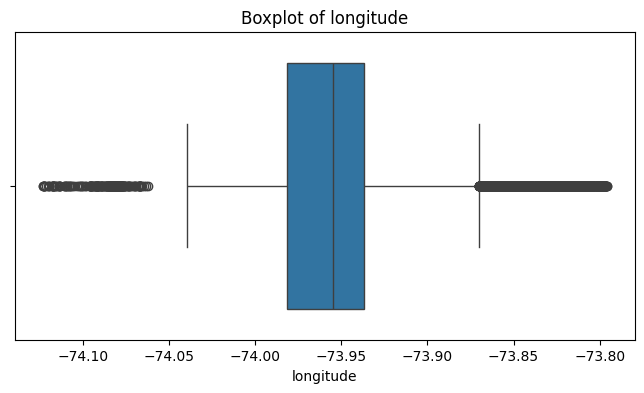

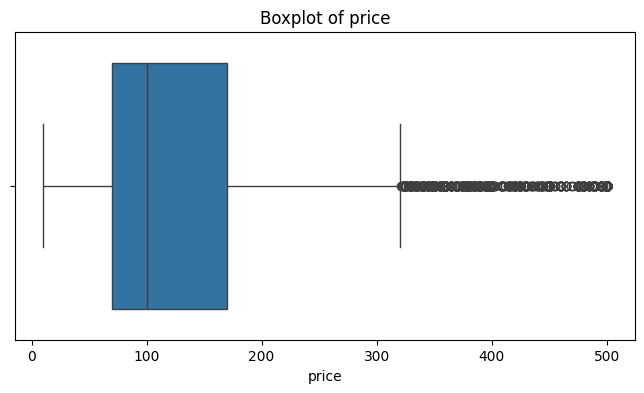

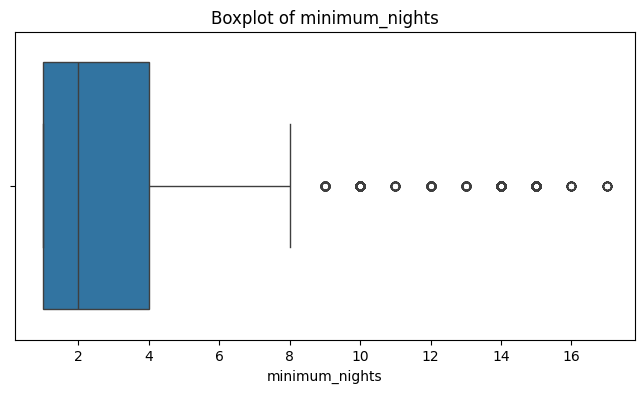

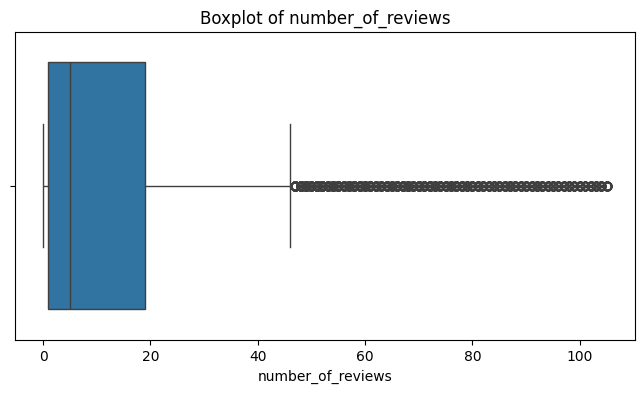

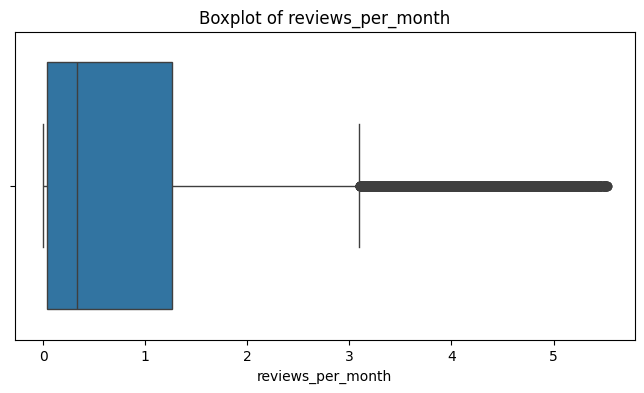

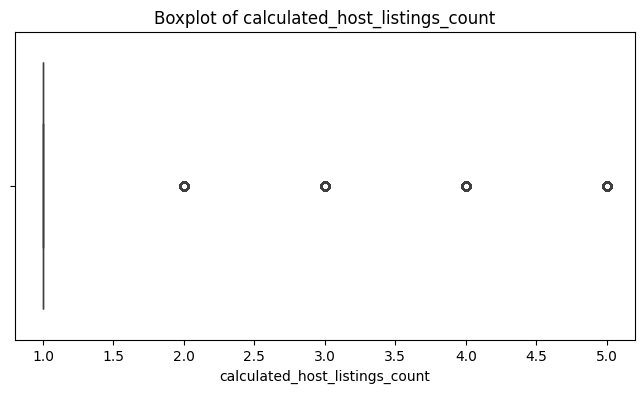

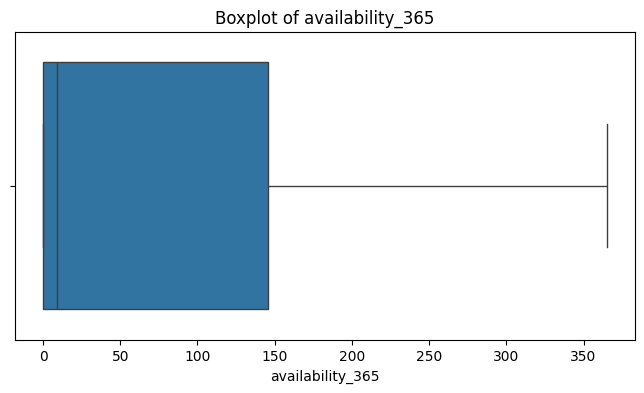

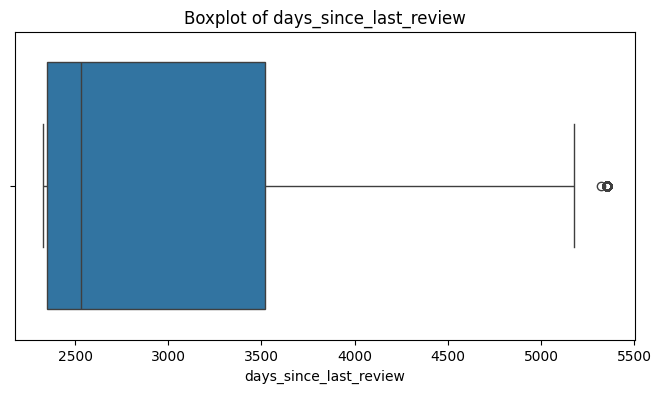

In [17]:
# plotting boxplots to identify outliers
for column in df2.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df2[column].dropna())
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

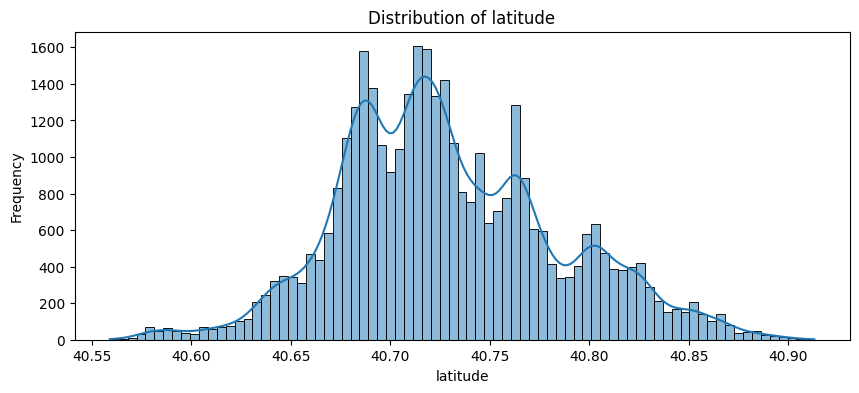

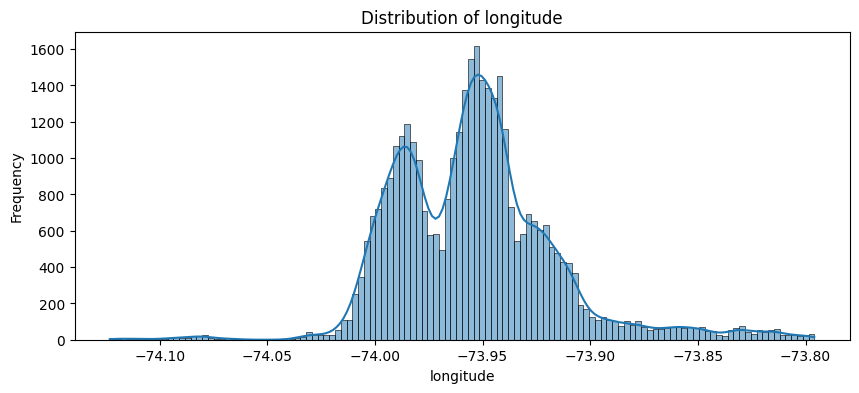

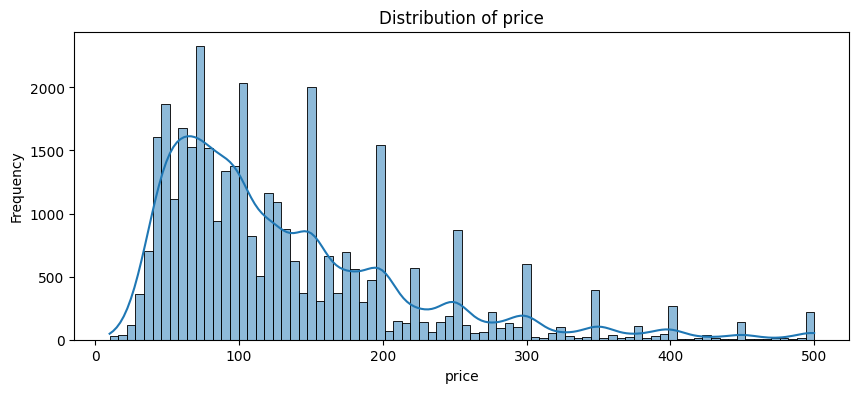

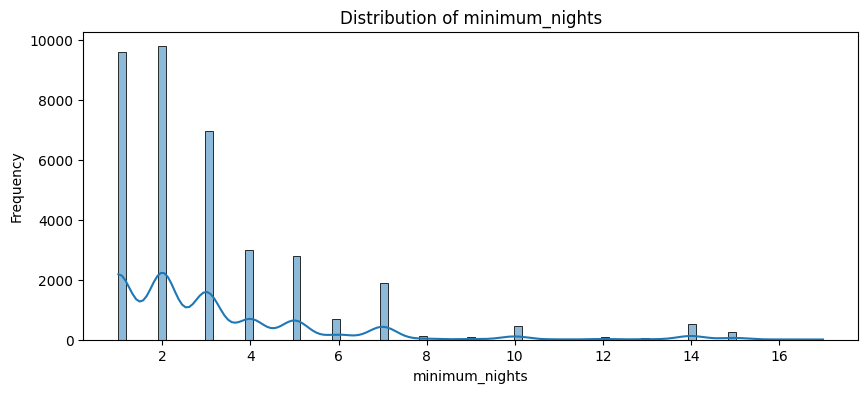

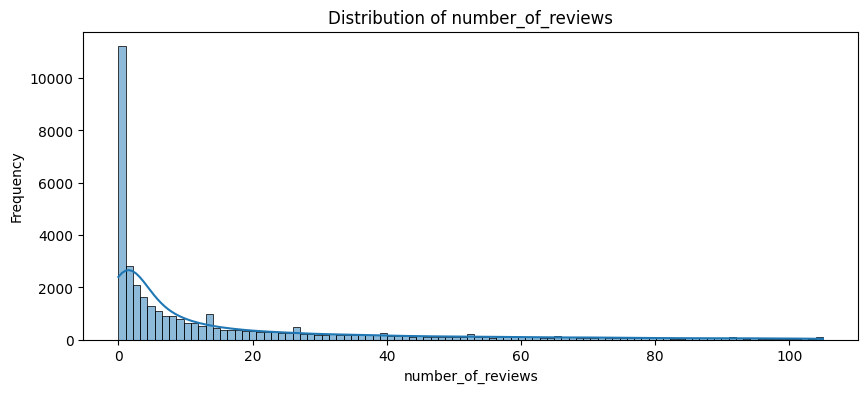

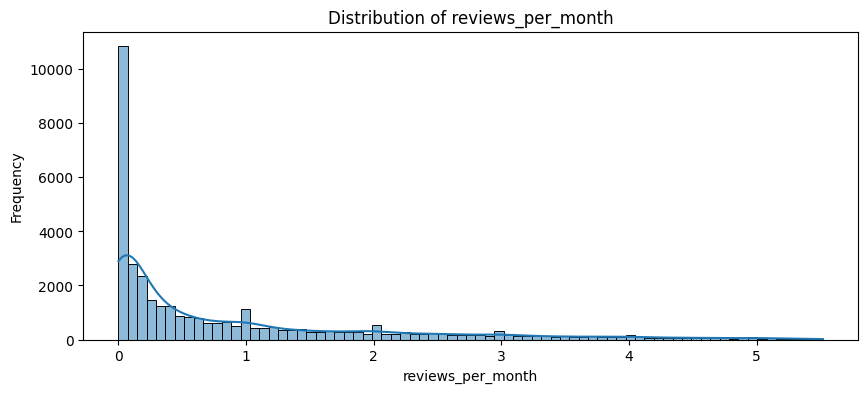

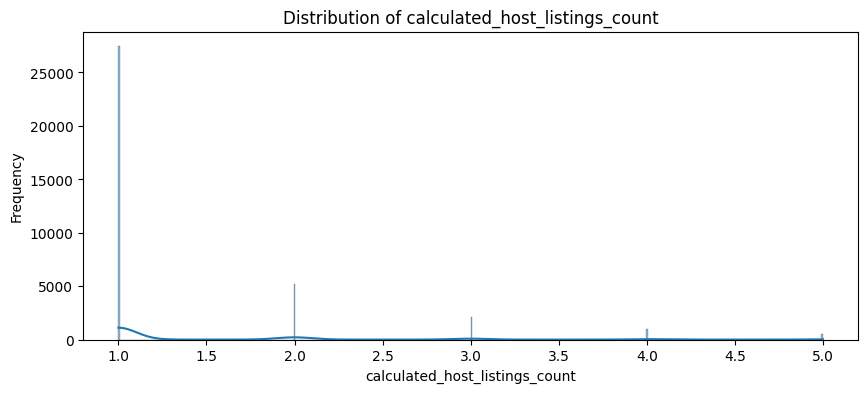

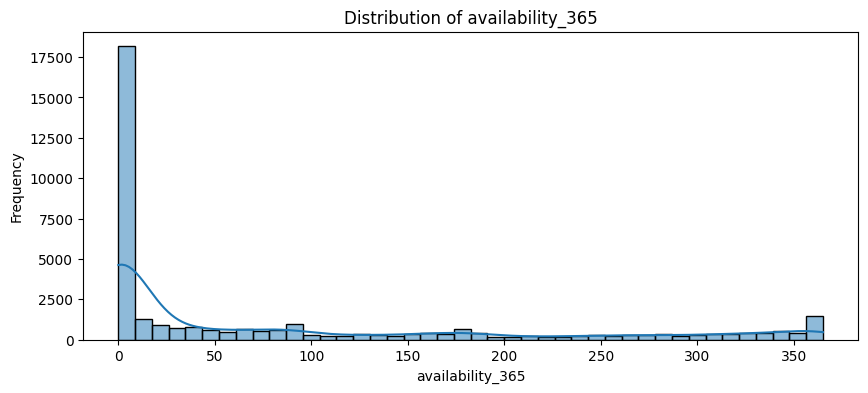

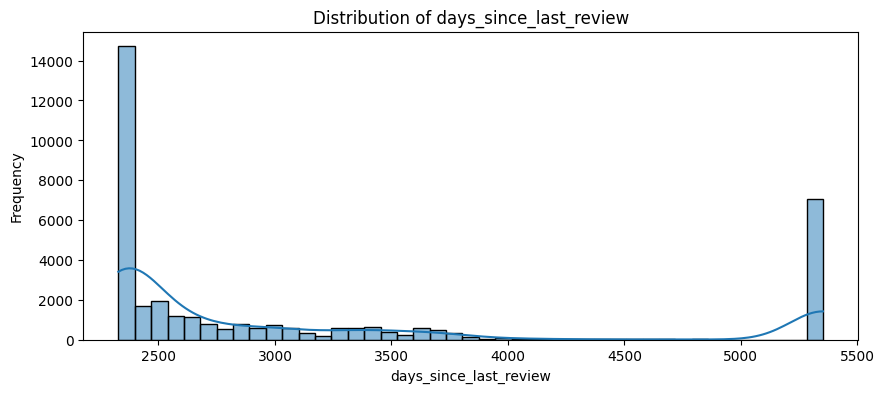

In [18]:
for column in df2.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df2[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

- After outlier handling, some features remain highly skewed. This is expected because winsorization clips extreme noise but does not and should not reshape the natural distribution. Ensembled models (e.g. Random Forest and Gradient Boosting) naturally handle with it.

In [19]:
# applying log transformation to reviews_per_month, number_of_reviews and availability_365
for col in ['reviews_per_month', 'number_of_reviews', 'availability_365']:
    if col in df2.columns:
        df2[col] = df2[col].apply(lambda x: np.log1p(x))

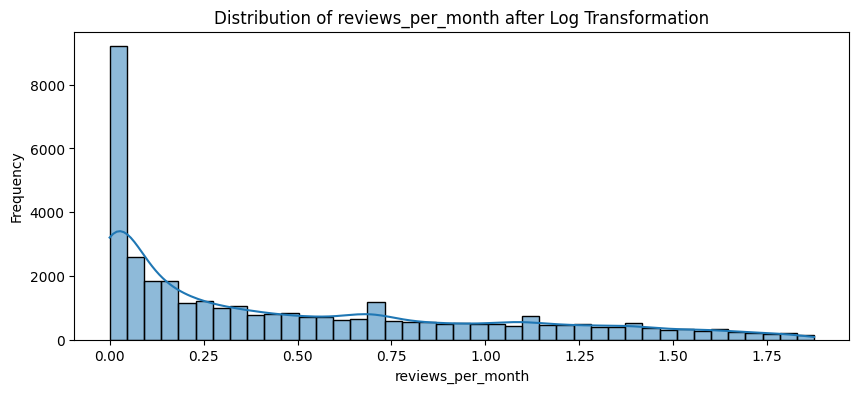

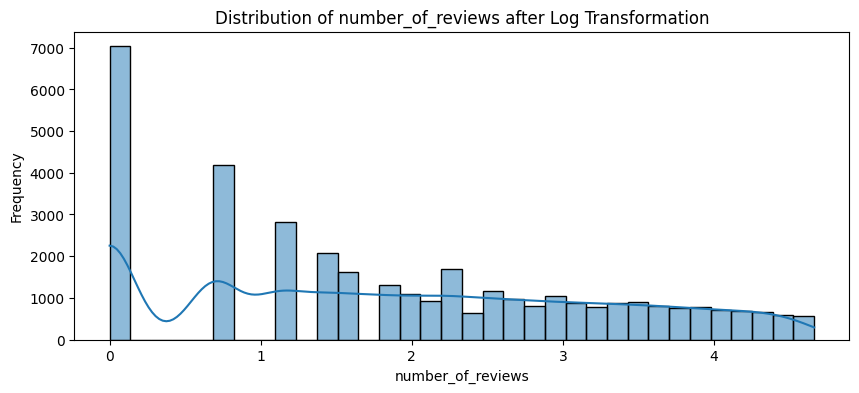

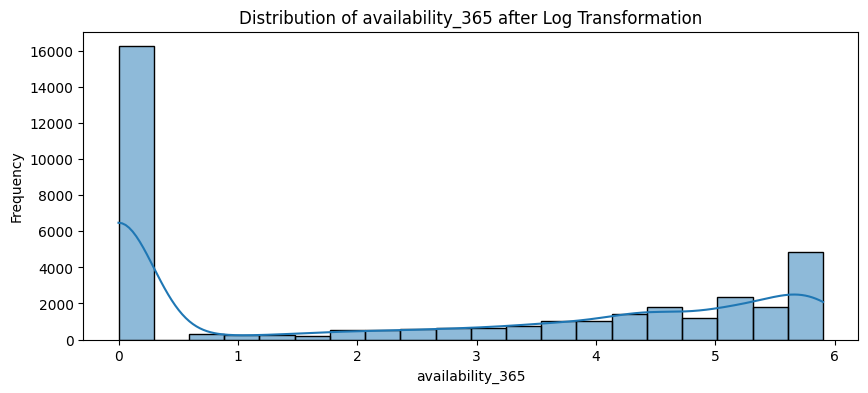

In [20]:
# visualizing distributions after log transformation
for column in ['reviews_per_month', 'number_of_reviews', 'availability_365']:
    plt.figure(figsize=(10, 4))
    sns.histplot(df2[column].dropna(), kde=True)
    plt.title(f'Distribution of {column} after Log Transformation')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

- The embedding of the categorical values will be done after split the data into train-test-validation data to avoid *data leakage*.

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36365 entries, 1 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             36365 non-null  object 
 1   neighbourhood                   36365 non-null  object 
 2   latitude                        36365 non-null  float64
 3   longitude                       36365 non-null  float64
 4   room_type                       36365 non-null  object 
 5   price                           36365 non-null  int64  
 6   minimum_nights                  36365 non-null  int64  
 7   number_of_reviews               36365 non-null  float64
 8   reviews_per_month               36365 non-null  float64
 9   calculated_host_listings_count  36365 non-null  int64  
 10  availability_365                36365 non-null  float64
 11  days_since_last_review          36365 non-null  Int64  
dtypes: Int64(1), float64(5), int64(3), ob

## **2.2.** Splitting into training, test and validation data.

In [22]:
target_col = "price"

feature_cols = [
    "latitude",
    "longitude",
    "minimum_nights",      
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "days_since_last_review",
    "neighbourhood_group",
    "neighbourhood",
    "room_type",
]

X = df2[feature_cols].copy()
y = df2[target_col].values


In [23]:
from sklearn.model_selection import train_test_split

# Separating the test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Separating the remaining 80% into train (60%) and val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

X_train.shape, X_val.shape, X_test.shape

((21819, 11), (7273, 11), (7273, 11))

In [24]:
# Separating categorical and numerical columns
numeric_cols = [
    "latitude",
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "days_since_last_review",
]

categorical_cols = [
    "neighbourhood_group",
    "neighbourhood",
    "room_type",
]


- Besides the dataset has no missing values, imputation was included for robustness, since log transformation can add NaN values, when applied to negative and zero values.

In [25]:
# Preprocessing numerical features: imputation and scaling

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()

X_train_num = num_imputer.fit_transform(X_train[numeric_cols])
X_val_num   = num_imputer.transform(X_val[numeric_cols])
X_test_num  = num_imputer.transform(X_test[numeric_cols])

X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_val_num_scaled   = num_scaler.transform(X_val_num)
X_test_num_scaled  = num_scaler.transform(X_test_num)

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36365 entries, 1 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             36365 non-null  object 
 1   neighbourhood                   36365 non-null  object 
 2   latitude                        36365 non-null  float64
 3   longitude                       36365 non-null  float64
 4   room_type                       36365 non-null  object 
 5   price                           36365 non-null  int64  
 6   minimum_nights                  36365 non-null  int64  
 7   number_of_reviews               36365 non-null  float64
 8   reviews_per_month               36365 non-null  float64
 9   calculated_host_listings_count  36365 non-null  int64  
 10  availability_365                36365 non-null  float64
 11  days_since_last_review          36365 non-null  Int64  
dtypes: Int64(1), float64(5), int64(3), ob

## **2.3.** Embedding categorical features

In [27]:
#see unique values in categorical columns
for col in categorical_cols:
    print(f"Unique values in '{col}': {X_train[col].unique()}")

Unique values in 'neighbourhood_group': ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island']
Unique values in 'neighbourhood': ['Harlem' 'Clinton Hill' 'Upper West Side' 'Richmond Hill' 'Crown Heights'
 'Chelsea' 'Flatbush' 'Upper East Side' 'Park Slope' 'Williamsburg'
 'Jamaica Hills' 'Bedford-Stuyvesant' 'South Slope' 'Nolita' 'Midtown'
 'Bushwick' 'Brooklyn Heights' 'East Village' 'Washington Heights'
 'Sunset Park' 'East Flatbush' 'Morningside Heights' 'Flatiron District'
 'Prospect Heights' 'Murray Hill' 'Boerum Hill' 'Cobble Hill' 'Elmhurst'
 'Dyker Heights' 'Woodlawn' 'East New York' 'East Harlem'
 'Windsor Terrace' 'Little Italy' 'Lower East Side' 'Greenpoint' 'Astoria'
 'Long Island City' 'SoHo' 'Greenwich Village' 'Ridgewood' 'Kips Bay'
 'Canarsie' 'Flushing' 'Tribeca' 'Gramercy' 'Fort Greene' "Hell's Kitchen"
 'Concourse' 'Gowanus' 'Parkchester' 'Rego Park' 'Ditmars Steinway'
 'West Village' 'Brownsville' 'Pelham Gardens' 'Throgs Neck' 'Chinatown'
 'Cypress Hills' 'Jack

- Besides dataset has no missing categorical values, imputation was . The idea is to eliminate the possibility of the data, in a workflow, to have any missing value.

- Although, its a good idea to use a model to predict the categorical values, it handles to a more complex tasks (e.g. EDA, Data Preprocessing etc) in the dataset, only to imput some values and prepare the data to the main model. So, the method of imput chosen was "most_frequent".

- About the encoding method, label encoding would be a good method, **but** the lack of natural ordinal meaning in the categorical values. Besides **apparently** there is a ordinal characteristic in "room_type", it doesn't has: in *real life* a "shared room" can be more expensive than a "Private room", depending of the furnitures and arrangement, or even the place. The same reason can be applied in the *neighbourhood_group*.

In [28]:
# categorical preprocessing: imputation and one-hot encoding
cat_imputer = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
X_val_cat   = cat_imputer.transform(X_val[categorical_cols])
X_test_cat  = cat_imputer.transform(X_test[categorical_cols])

X_train_cat_ohe = ohe.fit_transform(X_train_cat)
X_val_cat_ohe   = ohe.transform(X_val_cat)
X_test_cat_ohe  = ohe.transform(X_test_cat)

In [29]:
# Combining numerical and categorical features
X_train_final = np.hstack([X_train_num_scaled, X_train_cat_ohe])
X_val_final   = np.hstack([X_val_num_scaled,   X_val_cat_ohe])
X_test_final  = np.hstack([X_test_num_scaled,  X_test_cat_ohe])

X_train_final.shape, X_val_final.shape, X_test_final.shape

((21819, 195), (7273, 195), (7273, 195))

- Doing the embedding after to split the dataset helps to avoid the data leakage.

# **3. MODELS**

## **3.1.** *Linear Regression* (simplest)

In [30]:
# initializing linear regression
lr = LinearRegression()

In [31]:
# training the model
lr.fit(X_train_final, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
# Predictions on validation set
y_val_pred_lr  = lr.predict(X_val_final)

# metrics calculation
lr_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
lr_val_r2   = r2_score(y_val, y_val_pred_lr)

print("Linear Regression Validation:")
print(f"  RMSE: {lr_val_rmse:.3f}")
print(f"  R2  : {lr_val_r2:.3f}\n")


Linear Regression Validation:
  RMSE: 64.635
  R2  : 0.465



In [33]:
# Predictions on test set
y_test_pred_lr = lr.predict(X_test_final)

# metrics calculation
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_test_r2   = r2_score(y_test, y_test_pred_lr)

print("Linear Regression Test:")
print(f"  RMSE: {lr_test_rmse:.3f}")
print(f"  R2  : {lr_test_r2:.3f}")

Linear Regression Test:
  RMSE: 64.517
  R2  : 0.465


- The results in Linear Regression model shows that:
    - **RMSE**= 64.517: *on average, the model’s prediction for the nightly price is off by U$64.52*.

    - **R2 score** = 0.465: means the model capturates roughly 47% of the price variance.

- These results were expected, snce the relation between **price**-**features** are non-linear.

- Since it's the simplest model, *Linear Regression* was very fast (less than 0.5s)

## **3.2.** *Random Forest regressor*

- The first reason to choose *Random Forest regressor* as a model it's because it handles with non-linearity naturally. Of course, it's a big advantage against models like *Linear Regression*.

- After the winsorization, some features still heavily skewed. And since Random Forest doesn't requires normal distribution, it makes it better than *Linear Regression*.

- ABout **Non-linear models**, Random FOrest isn't more sensitive to hyperparameters and easier to overfit (like in **Gradient Boosting**), doesn't have a poor performance in high-dimensional data ( since the *One-Hot encoding increased the dimensionality ofthe dataset) and handle well with mixed data (numeric, encoded and engineered features) and, by the end, doesn't requires more hyperparameters and tolerates high-cardinality (high number of unique values) in a feature like the **Support Vector Regression**

In [34]:
# Defining the best hyperparameters for Random Forest Regressor using RandomizedSearchCV
# Base model
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Hyperparameter search space
param_distributions = {
    "n_estimators": [100, 200, 400, 800],
    "max_depth": [None, 5, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5],
    "bootstrap": [True, False],
}

# Randomized search
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=30,       # number of combinations to try
    cv=3,            # 3-fold CV on the training set
    scoring="neg_root_mean_squared_error",  # we care about RMSE
    random_state=42,
    n_jobs=-1,
    verbose=2,
)

rf_search


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,30
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [35]:
rf_search.fit(X_train_final, y_train)

print("Best score (CV RMSE):", -rf_search.best_score_)
print("Best params:")
for k, v in rf_search.best_params_.items():
    print(f"  {k}: {v}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score (CV RMSE): 61.9779916544934
Best params:
  n_estimators: 800
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: 0.5
  max_depth: 20
  bootstrap: True


- The result of the Cross-validation RMSE means that *on average, the model's prediction are off U$62.00* which for a noisy data, it's reasonable result.

- About the other hyperparameters, having more *estimators* (or "trees") gives better averaging, reduces the risk of overfitting and are more robust to noise, but it increase the training time.

- *min_samples_split* being equal to 2 is to the model split whenever benefical.

- *min_samples_leaf* = 4 prevents the leaf nodes to have less than 4 samples, which reduces overfitting and smooths predictions.

- *max_features* = 0.5 increases the randomness and improves generalization, making the model considers only 50% of the features in each split.

- *bootstrap* = *True* leads to a more stable model across the folds and lower the variance (de-correlating the trees) by training each tree with bootstrapped sample of the data.

- The metrics used are:

    - **RMSE** (or *Root Mean Squared Error) is useful because it strongly penalizes large errors, provides a smooth and stable optimization surface, is expressed in the same units as the target (making interpretation easy), and suits continuous targets like price.

    - **R2 score** is useful because it indicates the proportion of variance in the target that the model explains, provides a normalized benchmark for comparing models, is widely used in many analytical fields, and complements RMSE by measuring model fit from a statistical perspective.

In [36]:
# Best Random Forest model found
rf_best = rf_search.best_estimator_

# Evaluating on validation set
y_val_pred = rf_best.predict(X_val_final)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.3f}")
print(f"Validation R2 : {val_r2:.3f}")

Validation RMSE: 62.683
Validation R2 : 0.497


- The RMSE in 62.68 indicates that *on average, the model’s prediction for the nightly price is off by U$62.68*.

- The result of R2 being *0.497* (approximately 0.500) means the model capturates roughly half of the variability. THis is expected, since the price of a room/house/apto can increase or decrease by things that cannot be found in this dataset, like pictures, furnitures etc.

In [37]:
# Evaluating on test set
y_test_pred = rf_best.predict(X_test_final)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test R2 : {test_r2:.3f}")

Test RMSE: 62.335
Test R2 : 0.500


- In test set, the results were similar if compared with te evaluation set.

## **3.3.** *Gradient Boosting Regressor*

- **Gradient Boosting** is a ensemble method that builds trees (like the *Random Forest*) sequentially, allowing it to correct the errors of previous trees and capture subtle nonlinear patterns in the data. This makes it well-suited for tabular datasets with engineered numeric features and one-hot-encoded categories. Gradient Boosting often achieves lower RMSE than Random Forest when tuned properly, making it a strong complementary model for Airbnb price prediction.

In [38]:
gbr_param_grid = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

gbr_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_param_grid,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

gbr_search.fit(X_train_final, y_train)

print("BEST GBR RMSE:", -gbr_search.best_score_)
print("BEST GBR PARAMS:")
for k, v in gbr_search.best_params_.items():
    print(f" {k}: {v}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
BEST GBR RMSE: 61.60529696522852
BEST GBR PARAMS:
 subsample: 0.6
 n_estimators: 500
 min_samples_split: 2
 min_samples_leaf: 4
 max_depth: 5
 learning_rate: 0.03


In [39]:
# best GBR model
gbr_best = gbr_search.best_estimator_

# Evaluating on validation set
y_val_pred = gbr_best.predict(X_val_final)
gbr_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
gbr_val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {gbr_val_rmse:.3f}")
print(f"Validation R2 : {gbr_val_r2:.3f}")

Validation RMSE: 62.157
Validation R2 : 0.505


In [40]:
# evaluating on test set
y_test_pred = gbr_best.predict(X_test_final)

gbr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gbr_test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {gbr_test_rmse:.3f}")
print(f"Test R2 : {gbr_test_r2:.3f}")

Test RMSE: 61.925
Test R2 : 0.507


- Results in **GBR** were slightly better than in the **Random Forest**. But the processing took more time in GBR making it not worth, if compared with the time in Random Forest.

    | Model | Time |
    |---|---|
    |**Linear Regression**| 0.2s |
    |**Random Forest**| 8min 51s
    |**GBR**| 17min 4s|

# **4.** Tracking the models with *MLflow*

In [41]:
MLFLOW_TRACKING_URI = "mlruns" 
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

EXPERIMENT_NAME = "AB_NYC_2019_Price_Regression_ManualPreproc"
mlflow.set_experiment(EXPERIMENT_NAME)

c:\Users\preda\Documents\Artificial_Intelligence\Term3\Software and emerging tools\activities\assignment2\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location=('file:c:/Users/preda/Documents/Artificial_Intelligence/Term3/Software and '
 'emerging tools/activities/assignment2/mlruns/729583867562440102'), creation_time=1763762671332, experiment_id='729583867562440102', last_update_time=1763762671332, lifecycle_stage='active', name='AB_NYC_2019_Price_Regression_ManualPreproc', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [42]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [43]:
models_to_train = []

# Linear Regression
models_to_train.append(
    ("linear_regression", LinearRegression(), {})
)

#  Random Forest with the best hyperparams from search
best_rf_params = {
    **rf_search.best_params_, 
    "random_state": 42,
    "n_jobs": -1,
}
models_to_train.append(
    ("random_forest_best", RandomForestRegressor(**best_rf_params), best_rf_params)
)

# 3) Simple Gradient Boosting (you can tune later if you want)
gbr_params = {
    **gbr_search.best_params_,
    "learning_rate": 0.05,
    "random_state": 42,
}
models_to_train.append(
    ("gradient_boosting", GradientBoostingRegressor(**gbr_params), gbr_params)
)

best_run_id = None
best_val_rmse = float("inf")
run_summaries = []

for model_name, model, params in models_to_train:
    print(f"\n=== Training model: {model_name} ===")
    with mlflow.start_run(run_name=model_name) as run:
        # Train
        model.fit(X_train_final, y_train)

        # Predict
        y_train_pred = model.predict(X_train_final)
        y_val_pred   = model.predict(X_val_final)
        y_test_pred  = model.predict(X_test_final)

        # Metrics
        metrics = {
            "train_rmse": rmse(y_train, y_train_pred),
            "train_mae": mean_absolute_error(y_train, y_train_pred),
            "train_r2": r2_score(y_train, y_train_pred),
            "val_rmse": rmse(y_val, y_val_pred),
            "val_mae": mean_absolute_error(y_val, y_val_pred),
            "val_r2": r2_score(y_val, y_val_pred),
            "test_rmse": rmse(y_test, y_test_pred),
            "test_mae": mean_absolute_error(y_test, y_test_pred),
            "test_r2": r2_score(y_test, y_test_pred),
        }

        # Log params & metrics
        if params:
            mlflow.log_params(params)
        mlflow.log_metrics(metrics)

        # Infer signature from training data and predictions
        signature = infer_signature(X_train_final, y_train_pred)

        # Use a small slice as input example
        input_example = X_train_final[:5]

        # Log model artifact
        mlflow.sklearn.log_model(
            sk_model=model,
            name="model",
            signature=signature,
            input_example=input_example,
        )

        print("Metrics:", {k: round(v, 3) for k, v in metrics.items()})

        run_summaries.append(
            {
                "run_id": run.info.run_id,
                "model_name": model_name,
                **metrics,
            }
        )

        # Track best model by validation RMSE
        if metrics["val_rmse"] < best_val_rmse:
            best_val_rmse = metrics["val_rmse"]
            best_run_id = run.info.run_id

# starting the process to launch MLflow UI
mlflow_proc = subprocess.Popen(
    ["mlflow", "ui", "--backend-store-uri", "mlruns", "--port", "5000"]
)

print("\n ######## Summary of runs #######")
pd.DataFrame(run_summaries)
time.sleep(5)

# open the MLflow UI in the default web browser
webbrowser.open("http://127.0.0.1:5000")




=== Training model: linear_regression ===


2025/11/21 21:22:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Metrics: {'train_rmse': np.float64(63.088), 'train_mae': 42.929, 'train_r2': 0.477, 'val_rmse': np.float64(64.635), 'val_mae': 43.967, 'val_r2': 0.465, 'test_rmse': np.float64(64.517), 'test_mae': 43.895, 'test_r2': 0.465}

=== Training model: random_forest_best ===


2025/11/21 21:22:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Metrics: {'train_rmse': np.float64(44.454), 'train_mae': 28.904, 'train_r2': 0.74, 'val_rmse': np.float64(62.683), 'val_mae': 41.613, 'val_r2': 0.497, 'test_rmse': np.float64(62.335), 'test_mae': 41.497, 'test_r2': 0.5}

=== Training model: gradient_boosting ===


2025/11/21 21:23:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Metrics: {'train_rmse': np.float64(53.677), 'train_mae': 36.265, 'train_r2': 0.621, 'val_rmse': np.float64(62.407), 'val_mae': 41.383, 'val_r2': 0.501, 'test_rmse': np.float64(62.023), 'test_mae': 41.131, 'test_r2': 0.505}

 ######## Summary of runs #######


True